## Berekening van lineare & annuiteitenhypotheek

Rekening houdend met inflatie (geldontwaarding). Er wordt een inflatiecorrectie toegepast op toekomstige bedragen zodat toekomstige bedragen te vergelijken zijn met de euro van nu.

De volgende zaken worden *niet* meegenomen:

- Wet hillen
- Eigenwoningforfait
- Eventueel verandering van de rente na afloop rentevaste periode
- Verandering van inkomstenbelasting gedurende de looptijd

**Openstaande vraag: los je met extra aflossen je hypotheek gewoon eerder af, of wordt het maandbedrag dusdanig verlaagd zodat je alsnog de 30 jaar looptijd houdt? Ik ga nu uit van het 1e scenario.**

In [333]:
from collections import namedtuple

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

INFLATION = 0.02  # Assumption of yearly inflation the next 30 years
INCOME_TAX = 0.4015  
#INCOME_TAX = 0.52

""""
r = jaarrente
m = maandrente
p = aantal periodes (30 jaar = 360 maanden)
h = hypotheekwaarde
"""

# r = 3.15/100
# m = r/12
# p = 360
# h = 339000

r = 2.34/100
m = r/12
p = 360
h = 228500

## Common hypotheek code

In [334]:
class Mortgage():
    def __init__(self, value, periods, interest_rate, extra_monthly_downpayment=0):
        self.value = value
        self.periods = periods
        self.interest_rate = interest_rate
        self.interest_rate_monthly = interest_rate/12
        self.extra_monthly_downpayment = extra_monthly_downpayment

    def calc(self):
        self.results = pd.DataFrame(columns=['Value', 'Interest\n(Gross)', 'Interest\n(Net)', 'Down-\npayment', 
                                             'Total\n(Gross)', 'Total\n(Net)', 'Total\n(Net,InfCorr)', 
                                             'CumInt(Gross)', 'CumInt(Net)', 'CumInt\n(Net,InfCorr)', 
                                             'CumDp'])
        remaining = self.value
        cum_int = 0
        cum_int_net = 0
        cum_int_net_infcorr = 0
        cum_dp = 0

        for month in range(self.periods+1):
            t = self._calc_monthly_amounts(month, remaining)
            remaining = t.remaining
            interest_net = t.interest - Mortgage._calc_interest_deduction(t.interest)

            cum_int += t.interest
            cum_int_net += interest_net
            cum_dp += t.downpayment
            
            total_net_infcorr = (interest_net+t.downpayment) * (1-INFLATION/12) ** month
            cum_int_net_infcorr += (interest_net) * (1-INFLATION/12) ** month

            if (month+1) % 12 != 0:
                continue

            year = int((month+1) / 12)
            
            self.results.loc[year, 'Value'] = round(remaining)
            self.results.loc[year, 'Interest\n(Gross)'] = round(t.interest)
            self.results.loc[year, 'Interest\n(Net)'] = round(interest_net)
            self.results.loc[year, 'Down-\npayment'] = round(t.downpayment)
            self.results.loc[year, 'Total\n(Gross)'] = round(t.interest+t.downpayment)
            self.results.loc[year, 'Total\n(Net)'] = round(interest_net+t.downpayment)
            self.results.loc[year, 'Total\n(Net,InfCorr)'] = round(total_net_infcorr)
            self.results.loc[year, 'CumInt(Gross)'] = round(cum_int)
            self.results.loc[year, 'CumInt(Net)'] = round(cum_int_net)
            self.results.loc[year, 'CumInt\n(Net,InfCorr)'] = round(cum_int_net_infcorr)
            self.results.loc[year, 'CumDp'] = round(cum_dp)
    
    @staticmethod
    def _calc_interest_deduction(interest):
        return interest * INCOME_TAX
        
    def _calc_monthly_amounts(self, month, remaining):
        raise NotImplementedError()
        

## Annuiteiten hypotheek code

### Toelichting berekening annuïteitenhypotheek
Bij het berekenen van de maandlast van een annuïteitenhypotheek, zijn de volgende variabelen van belang:

- $h$ = hypotheek = het uitstaande hypotheekbedrag
- $r$ = hypotheekrente = het te betalen rentepercentage (5% wordt 0,05)
- $p$ = periodes = het aantal betalingen, in dit geval de looptijd in maanden (bij 30 jaar 360)
- $a$ = annuïteit = de vaste maandlast bestaande uit hypotheekrente en aflossing

De hypotheekrente wordt altijd nominaal en per jaar weergegeven. Voor de maandlast, dienen we dit rentetarief om te rekenen naar een rente per maand.

maandrente = $m = r/12$

De formule om de annuïteit te berekenen is als volgt:

annuïteit = (maandrente / (1 - ((1 + maandrente) ^ -aantal periodes))) * hypotheekbedrag

$$a = \frac{m}{1-(1 + m)^{-p}} \cdot h$$


In [335]:
class Annuity(Mortgage):
    def __init__(self, value, periods, interest_rate, extra_monthly_downpayment=0):
        super().__init__(value, periods, interest_rate, extra_monthly_downpayment)
        self.annuity = self._calc_annuity()

    def _calc_monthly_amounts(self, month, remaining):    
        if remaining > 0:
            interest = self.interest_rate_monthly * remaining
            downpayment = self.annuity - interest
            
            if (self.extra_monthly_downpayment > 0):
                downpayment += self.extra_monthly_downpayment
                # Re-calculate annuity over adjusted value
                self.value = self.value - self.extra_monthly_downpayment
                self.annuity = self._calc_annuity()  

            if remaining - downpayment > 0:
                # Normal case
                remaining = remaining - downpayment
            else:
                # The very last period
                downpayment = remaining
                remaining = 0
        else:
            interest = 0
            downpayment = 0
            remaining = 0

        t = namedtuple("MonthlyDetails", ["interest", "remaining", "downpayment"])
        t.interest = interest
        t.downpayment = downpayment
        t.remaining = remaining
        return t
    
    def _calc_annuity(self):
        return self.interest_rate_monthly/(1-(1+self.interest_rate_monthly)**-self.periods)*self.value
    
annuity = Annuity(h, p, r)
annuity.calc()
annuity.results

,Value,Interest (Gross),Interest (Net),Down- payment,Total (Gross),Total (Net),"Total (Net,InfCorr)",CumInt(Gross),CumInt(Net),"CumInt (Net,InfCorr)",CumDp
1,223183,436,261,448,884,709,696,5290,3166,3137,5317
2,217739,425,255,458,884,713,686,10454,6257,6140,10761
3,212168,415,248,469,884,717,677,15490,9271,9009,16332
4,206464,404,242,480,884,722,667,20394,12206,11748,22036
5,200625,392,235,492,884,726,658,25163,15060,14358,27875
6,194649,381,228,503,884,731,650,29794,17831,16843,33851
7,188531,369,221,515,884,736,641,34283,20518,19204,39969
8,182268,356,213,528,884,741,632,38628,23119,21444,46232
9,175857,344,206,540,884,746,624,42824,25630,23565,52643
10,169294,331,198,553,884,751,616,46869,28051,25568,59206


Zie dit als baseline. Let op max netto maandelijks bedrag (1e jaar) en wat er netto aan rente is betaald is cumulatief na 30 jaar.

## Lineare hypotheek code

In [336]:
class Linear(Mortgage):
    def __init__(self, value, periods, interest_rate, extra_monthly_downpayment=0):
        super().__init__(value, periods, interest_rate, extra_monthly_downpayment)
        if extra_monthly_downpayment > 0:
            # TODO: implement self.extra_monthly_downpayment
            raise NotImplementedError("Extra monthly downpayment is not yet implemented for the linear mortgage.")
        self.monthly_downpayment = value/360
    
    def _calc_monthly_amounts(self, month, remaining):
        t = namedtuple("MonthlyDetails", ["interest", "remaining", "downpayment"])

        t.interest = remaining * self.interest_rate_monthly
        t.remaining = remaining - self.monthly_downpayment
        t.downpayment = self.monthly_downpayment
        
        return t

lin = Linear(h, 360, r)
lin.calc()
lin.results

,Value,Interest (Gross),Interest (Net),Down- payment,Total (Gross),Total (Net),"Total (Net,InfCorr)",CumInt(Gross),CumInt(Net),"CumInt (Net,InfCorr)",CumDp
1,220883,432,259,635,1067,893,877,5265,3151,3123,7617
2,213267,417,250,635,1052,884,851,10352,6196,6080,15233
3,205650,402,241,635,1037,875,826,15261,9134,8877,22850
4,198033,387,232,635,1022,867,801,19991,11965,11519,30467
5,190417,373,223,635,1007,858,777,24544,14689,14011,38083
6,182800,358,214,635,992,849,754,28918,17307,16358,45700
7,175183,343,205,635,978,840,731,33114,19819,18565,53317
8,167567,328,196,635,963,831,709,37131,22223,20636,60933
9,159950,313,187,635,948,822,688,40971,24521,22577,68550
10,152333,298,179,635,933,813,667,44632,26712,24390,76167


Linear begint veel hoger het 1e jaar, maar is na jaar 30 wel een aardig stuk goedkoper gebleken dan annuitair aan cumulatieve rente-uitgaven. En na 10 jaar heb je significant meer afgelost. 

Maar wat nu als we annuitair doen met extra aflossen? Kies het bedrag waarmee de kosten even hoog uitkomen als linear in het 1e jaar:

## Annuitair met extra aflossen
Op zo'n manier dat je in het 1e jaar niet meer betaalt dan met linear

In [337]:
annuity_kort = Annuity(h, p, r, extra_monthly_downpayment=241)
annuity_kort.calc()
annuity_kort.results

,Value,Interest (Gross),Interest (Net),Down- payment,Total (Gross),Total (Net),"Total (Net,InfCorr)",CumInt(Gross),CumInt(Net),"CumInt (Net,InfCorr)",CumDp
1,220321,431,258,684,1115,942,925,5259,3148,3119,8179
2,212085,415,248,689,1104,937,902,10327,6180,6065,16415
3,203789,399,239,694,1092,932,879,15201,9098,8842,24711
4,195433,382,229,699,1081,928,858,19880,11898,11456,33067
5,187015,366,219,704,1070,923,836,24363,14581,13910,41485
6,178534,350,209,709,1059,918,816,28648,17146,16209,49966
7,169988,333,199,715,1048,914,796,32734,19591,18359,58512
8,161375,316,189,720,1036,909,776,36620,21917,20362,67125
9,152694,299,179,726,1025,905,757,40303,24121,22223,75806
10,143944,282,169,732,1014,901,739,43782,26204,23946,84556


Not bad! Na een periode van 10 jaar heb je zo meer afgelost dan met linear, je bent 4 jaar eerder van de hypotheek af, en je hebt minder rente betaald, terwijl de max maandlasten in jaar 1 niet hoger uitkomen dan linear. En je houdt flexibiliteit om minder af te lossen als het tegenzit.

### Plots van annuiteiten hypotheek

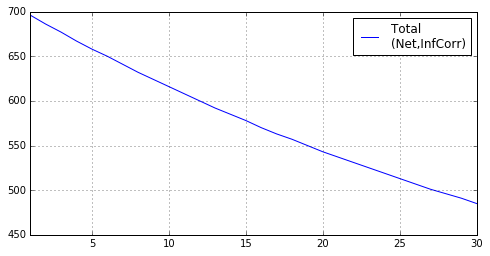

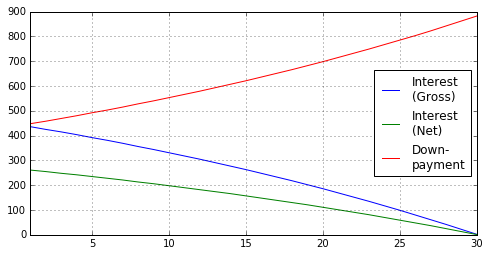

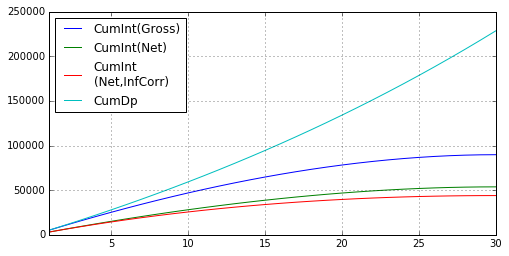

In [338]:
def plots(df):
    kwargs = {"grid": True, "figsize": (8,4)}
    df.plot(y=['Total\n(Net,InfCorr)'], **kwargs)
    df.plot(y=['Interest\n(Gross)', 'Interest\n(Net)', 'Down-\npayment'], **kwargs)
    df.plot(y=['CumInt(Gross)', 'CumInt(Net)', 'CumInt\n(Net,InfCorr)', 'CumDp'], **kwargs)
plots(annuity.results)

### Plots van lineare hypotheek

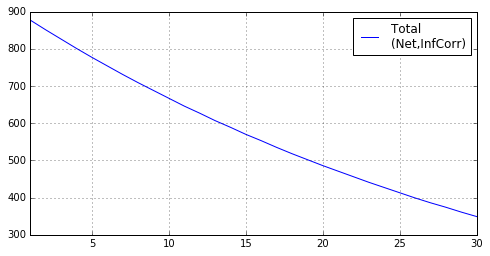

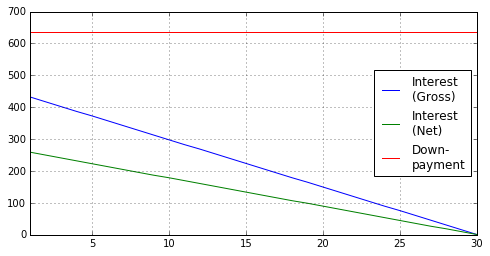

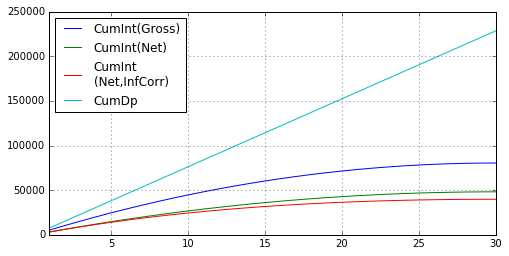

In [339]:
plots(lin.results)

### Vergelijken

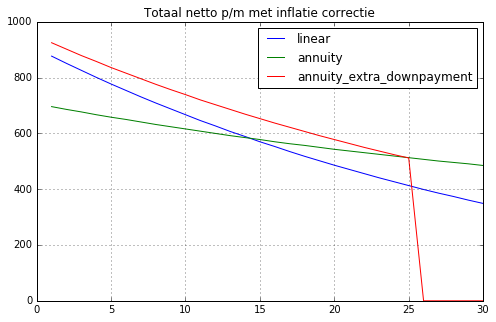

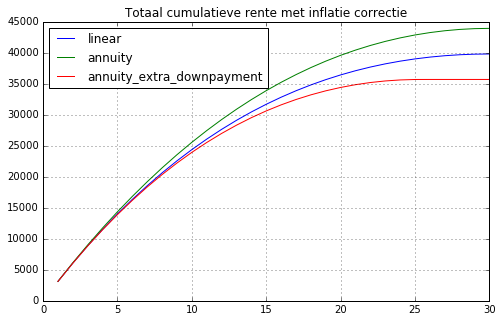

In [340]:
def compare_plot(dfs: dict, field, title):
    plt.figure(figsize=(8,5))
    for k, v in dfs.items():
        plt.plot(v.index, v[field], label=k)
    plt.grid()
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

dfs = {"annuity": annuity.results, "linear": lin.results, "annuity_extra_downpayment": annuity_kort.results}
compare_plot(dfs, 'Total\n(Net,InfCorr)', "Totaal netto p/m met inflatie correctie")
compare_plot(dfs, 'CumInt\n(Net,InfCorr)', "Totaal cumulatieve rente met inflatie correctie")